In [1]:
from data import extract_sentences
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import torch

lang = "de"

# Load the data
sentences = extract_sentences(lang)

1000it [00:00, 50132.12it/s]
998it [00:00, 52655.01it/s]
998it [00:00, 50033.65it/s]
1000it [00:00, 37135.81it/s]
1000it [00:00, 34574.52it/s]
1000it [00:00, 27851.92it/s]


# Encoder self-attention

In [2]:
import random
random.seed(111)

# Extract the attention
ambiguous_attention = defaultdict(list)
unambiguous_attention = defaultdict(list)
for sent in tqdm.tqdm(sentences):
    ambiguous_idx = sent.index_select(1, tags=["NOUN"])
    unambiguous_idx = [x for x in sent.index_select(0, tags=["NOUN"])]
    if unambiguous_idx:
        unambiguous_idx = random.sample(unambiguous_idx, 1)

    if ambiguous_idx:
        ambiguous_idx = random.sample(ambiguous_idx, 1)
    context_idx = sent.index_select(0, tags=["NOUN"], no_subtokens=True)

    if ambiguous_idx and unambiguous_idx and context_idx:
        amb_context_idx = [x for x in context_idx if x not in ambiguous_idx and \
                           ambiguous_idx[0] - 10 < x < ambiguous_idx[0] + 11]
        unamb_context_idx = [x for x in context_idx if x not in unambiguous_idx and \
                             unambiguous_idx[0] - 11 < x < unambiguous_idx[0] + 11]

        if amb_context_idx and unamb_context_idx:
            attention = torch.index_select(sent.attention, index=torch.LongTensor(ambiguous_idx), dim=-2)
            attention = torch.index_select(attention, index=torch.LongTensor(
                amb_context_idx), dim=-1)
            for l in range(6):
                ambiguous_attention[l].append(torch.mean(attention[l, :]).item())

            attention = torch.index_select(sent.attention, index=torch.LongTensor(unambiguous_idx), dim=-2)
            attention = torch.index_select(attention, index=torch.LongTensor(unamb_context_idx), dim=-1)
            for l in range(6):
                unambiguous_attention[l].append(torch.mean(attention[l, :]).item())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5990/5990 [00:13<00:00, 441.84it/s]


In [ ]:
# Visualise the results
sns.set_context("talk")

ambiguous = [x for l in range(6) for x in ambiguous_attention[l]]
unambiguous = [x for l in range(6) for x in unambiguous_attention[l]]
layers = [l for l in range(6) for x in unambiguous_attention[l]]
hues = ["amb." for _ in layers] + ["other" for _ in layers]

colours = sns.color_palette("cubehelix", 6)
plt.figure(figsize=(4, 4))
ax = sns.boxplot(x=layers + layers, y=ambiguous + unambiguous,
                 hue=hues, palette=[colours[1], colours[-1]], fliersize=0)

plt.tight_layout()
ax.set_xlabel("layer")
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_ylabel("attention")
plt.legend(bbox_to_anchor=(0.99, 1), frameon=False)
plt.ylim(-0.001, 0.15)

plt.savefig(f"figures/wsd_attention_to_context_{lang}.pdf", bbox_inches="tight")
plt.show()

# Encoder-decoder attention

In [4]:
import random

# Extract the attention
ambiguous_attention = defaultdict(list)
unambiguous_attention = defaultdict(list)
for sent in tqdm.tqdm(sentences):
    if sum(sent.tokenised_annotation) > 1:
        continue
    eos_index = sent.translation.index("</s>")
    translation = sent.translation[:eos_index + 1]
    
    align_src2tgt = defaultdict(list)
    for i in range(eos_index + 1):
        index = torch.argmax(torch.mean(sent.cross_attention[-1, :, i, :-1], dim=0), dim=-1)
        align_src2tgt[index.item()].append(i)

    amb_src_indices = torch.LongTensor(sent.index_select(1, tags=["NOUN"]))
    unamb_src_indices = [x for x in sent.index_select(0, tags=["NOUN"]) \
                         if x == len(sent.tokenised_annotation) - 1 or sent.not_subtoken(x + 1)]
    if len(unamb_src_indices) > 0:
        unamb_src_indices = random.sample(unamb_src_indices, 1)
    unamb_src_indices = torch.LongTensor(unamb_src_indices)
    amb_tgt_indices = [j for i in amb_src_indices for j in align_src2tgt[i.item()]]
    amb_tgt_indices = torch.LongTensor(sorted(list(set(amb_tgt_indices))))
    unamb_tgt_indices = [j for i in unamb_src_indices for j in align_src2tgt[i.item()]]
    unamb_tgt_indices = torch.LongTensor(sorted(list(set(unamb_tgt_indices))))  
    
    if len(amb_tgt_indices) > 0 and len(unamb_tgt_indices) > 0:
        attention = torch.index_select(sent.cross_attention, index=torch.LongTensor(amb_tgt_indices), dim=-2)
        attention = torch.index_select(attention, index=torch.LongTensor(amb_src_indices), dim=-1)
        for layer in range(6):
            ambiguous_attention[layer].append(torch.mean(attention[layer, :]))

        attention = torch.index_select(sent.cross_attention, index=torch.LongTensor(unamb_tgt_indices), dim=-2)
        attention = torch.index_select(attention, index=torch.LongTensor(unamb_src_indices), dim=-1)

        for layer in range(6):
            unambiguous_attention[layer].append(torch.mean(attention[layer, :]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5990/5990 [00:31<00:00, 191.29it/s]


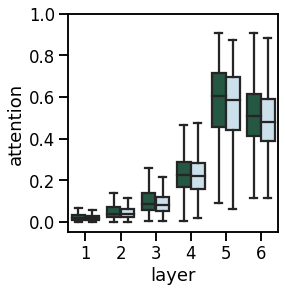

In [5]:
# Visualise the results
plt.figure(figsize=(4, 4))
sns.set_context("talk")

ambiguous = [x.item() for l in range(6) for x in ambiguous_attention[l]]
unambiguous = [x.item() for l in range(6) for x in unambiguous_attention[l]]
layers = [l for l in range(6) for x in unambiguous_attention[l]]
hues = ["ambiguous" for _ in layers] + ["other" for _ in layers]

colours = sns.color_palette("cubehelix", 6)

ax = sns.boxplot(x=layers + layers, y=ambiguous + unambiguous,
                 hue=hues, palette=[colours[1], colours[-1]], fliersize=0)
plt.tight_layout()

ax.set_xlabel("layer")
plt.xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_ylabel("attention")
plt.legend([],[], frameon=False)
plt.ylim(-0.05, 1)
plt.savefig(f"figures/wsd_cross_attention_{lang}.pdf", bbox_inches="tight")
plt.show()